### Packages and global variables

In [ ]:
########################### Packages
import sys
import math 
import random
from os import listdir
from collections import Counter

import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from PIL import Image

########################### Global Variables
data_path = '/mnt/data/N200_ordered/'

def seq_to_coords(data):
    '''Function which returns a tuple made as follow:
    (fcx,fcy,fcz,X,Y,Z) starting from the seqence (list)
    called "data".
    Explanation:
        fcx,fcy,fcz are lists of the coordinates of all
        of the sequence
        X,Y,Z are lists of coordinates of vetices only  
    '''
    
    cx, cy, cz = 0, 0, 0
    fcx,fcy,fcz = [cx],[cy],[cz]
    X,Y,Z = [cx],[cy],[cz]

    N = len(data)

    for i in range(0,N):
        if data[i]=='0':
            cx+=1
        elif data[i]=='1':
            cy+=1
        elif data[i]=='2':
            cz+=1        
        elif data[i]=='3':
            cx-=1
        elif data[i]=='4':
            cy-=1
        elif data[i]=='5':
            cz-=1

        fcx.append(cx)
        fcy.append(cy)
        fcz.append(cz)

        if i < (N-1) and data[i] != data[i+1]:
            X.append(cx)
            Y.append(cy)
            Z.append(cz)

        # Only vertices
        # Even if the last point is NOT a vertex
        # nevertheless it is considered such
        if i == (N-1):
            X.append(cx)
            Y.append(cy)
            Z.append(cz)

    # Making all coordinates positive
    minx,miny,minz=np.amin(fcx),np.amin(fcy),np.amin(fcz)
    fcx = np.array(fcx)
    fcy = np.array(fcy)
    fcz = np.array(fcz)
    fcx += abs(minx)
    fcy += abs(miny)
    fcz += abs(minz)

    minX,minY,minZ=np.amin(X),np.amin(Y),np.amin(Z)
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    X += abs(minX)
    Y += abs(minY)
    Z += abs(minZ)
    
    # Understanding which between the first or 
    # the last point in (X,Y,Z) is a vertex
    
    # first is NOT a vertex
    if (abs(np.sign(X[1]-X[-1])) 
        + abs(np.sign(Y[1]-Y[-1])) 
        + abs(np.sign(Z[1]-Z[-1]))) == 1:
        X = X[1:]
        Y = Y[1:]
        Z = Z[1:]

    # last is NOT a vertex
    if (abs(np.sign(X[-2]-X[0])) 
        + abs(np.sign(Y[-2]-Y[0])) 
        + abs(np.sign(Z[-2]-Z[0])))==1:
        X = X[:-1]
        Y = Y[:-1]
        Z = Z[:-1]
        
    return (fcx,fcy,fcz,X,Y,Z)
    

def dihedral(p1,p2,p3,X,Y,Z):
    '''Function which computes generalized dihedral angle
    This is a vectorize funzion, which computes the dihedral
    angle with respect to a vector points: X, Y, Z
    '''
    
    # ------ q1
    q1 = p2 - p1 # v_(i-1)
    
    # ------ q2
    q2 = p3 - p2 # v_i
    q2_hat = q2/np.sqrt(np.dot(q2,q2))
    
    # ------ q3
    # x = [1,2,3]
    # roll(x,-1) -> [2,3,1]
    tx = np.roll(X,-1) - X
    ty = np.roll(Y,-1) - Y
    tz = np.roll(Z,-1) - Z
    
    n = len(tx)
    q3 = np.hstack((tx.reshape(n,1),
                    ty.reshape(n,1),
                    tz.reshape(n,1)))
    # q3 = [[vx1,vy1,vz1], primo vettore
    #       [vx2,vy2,vz2],
    #       ...
    #       [vxn,vyn,vzn]]
    
    # norma per ogni riga e reshape per farlo diventare
    # un vettore colonna (serve per broadcasting)
    norm = np.linalg.norm(q3,axis=1).reshape(n,1)
    q3_hat = q3/norm
    # ------- /q3
    
    q1_x_q2 = np.cross(q1,q2)
    n1 = q1_x_q2/np.sqrt(np.dot(q1_x_q2,q1_x_q2))
    
    # Qui n2 e u2 hanno la stessa forma di q3 (e q3_hat)
    n2 = np.cross(q2_hat,q3_hat) # broadcasting di q2_hat per ogni riga di q3!
    u2 = np.cross(q2_hat,n2)
    
    # con dot non funziona il broadcasting :C
    cos_theta = np.array([n1.dot(v) for v in n2]) # vettore riga!!
    sin_theta = np.array([n1.dot(v) for v in u2])
    
    return -np.arctan2(sin_theta,cos_theta)


def edist(x1,y1,z1,X,Y,Z):
    '''Returns a vector of distances from x1, y1, z1
    '''
    tx = (x1-X)**2
    ty = (y1-Y)**2
    tz = (z1-Z)**2
    return np.sqrt(tx + ty + tz)


def matrix_pad(m, filter_shape):
    '''
    This function returns the input matrix m with "periodic padding".
        NB: The matrix and the filter are assumed to be 2 dimensional, and can be also rectangular matrices.
            The assumption of m and filter being square matrices could be considered to speed the code by declaring their dimensions insted of using np.shape (maybe)
    filter_shape is the shape of the mask; it can be a tuple or an integer if the mask is a square matrix.    
    '''
    
    # create a tuple from the filter shape if filter_shape is an integer (so square mask, following the "create_model()" function notation)
    if isinstance(filter_shape, int):
        filter_shape = tuple([filter_shape]*len(m.shape))
    
    # shape of the padded matrix and initialization
    new_shape = tuple([sum(x) for x in zip(m.shape, filter_shape)])
    m_pad = np.zeros(shape = new_shape)
    
    # filling the padding matrix. the 2-dimensionality of m is assumed here; may be generalized.
    m_pad[:m.shape[0], :m.shape[1]] = m  # filling with the original matrix
    m_pad[m.shape[0]:, :m.shape[1]] = m[:filter_shape[0], :] # filling the rows under m with the first L rows of m
    m_pad[:m.shape[0], m.shape[1]:] = m[:, :filter_shape[1]] # filling the columns at the right of m with the first L columns of m
    m_pad[m.shape[0]:, m.shape[1]:] = m[:filter_shape[0], :filter_shape[1]] # filling the remained empty square in the diagonal
    
    return m_pad


def to_binary(label):
    '''Return the label vector as:
    Unknotted -> 0
    knotted -> 1
    '''
    
    mask_unk = (label == 'UN')
    mask_kn = (label != 'UN')
    label[mask_unk] = 0
    label[mask_kn] = 1
    
    return label

# CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, LSTM
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras import initializers, optimizers, regularizers, activations
import gc # garbage collector

### CNN topology

In [ ]:
def create_model(input_shape=(200,200,1), # rows, cols, channels, NOTE: is the input shape BEFORE the periodic padding
                 init = initializers.he_normal(), # using He inizialization
                 n_class=1,               # number of neuron last layer (classes)
                 summary=False            # verbose
                ):
  
    filter_shape = 16 # filter shape for the first Conv Layer
        
    # Redefining the input shape to consider the periodic padding, adding the dimension of the filter
    if isinstance(filter_shape, int):
        filter_shape_tuple = tuple([filter_shape]*(len(input_shape)-1)) + tuple([0])
    # Summing the input_shape and the filter_shape, taking care of preserving the 1 in (,,1).
    input_shape = tuple([sum(x) for x in zip(input_shape, filter_shape_tuple)])
    
    
    model = Sequential()
    model.add( Conv2D(filters = 32,
                      kernel_size = filter_shape, 
                      activation = 'relu',
                      input_shape = input_shape,
                      padding = 'same',
                      strides = (4,4)
                      ) )
    model.add( Conv2D(filters = 48,
                      kernel_size = 8, 
                      activation = 'relu',
                      padding = 'same',
                      strides = (2,2)
                      ) )
    model.add( Conv2D(filters = 48,
                      kernel_size = 4, 
                      activation = 'relu',
                      padding = 'same',
                      ) )
    model.add( MaxPooling2D(pool_size = (2,2),
                            strides = (2,2),
                            padding='valid'
                               ) )  
    model.add( Conv2D(filters = 32,
                      kernel_size = 4, 
                      activation = 'relu',
                      padding = 'same',
                      ) )
    model.add( MaxPooling2D(pool_size = (2,2),
                            padding='valid'
                            ) ) 
    model.add( Dropout(.35) )
    model.add( Flatten() )
    model.add( Dense(186, 
                     activation = 'relu',
                     #kernel_regularizer = l1_l2(0.01,0.01)
                     ) )
    model.add( Dropout(.75) )
    model.add(Dense(n_class, activation='sigmoid')) 
    
    # print model's details
    if summary: print(model.summary())
    
    # Compiling model
    model.compile(loss = binary_crossentropy,
                  optimizer = optimizers.Nadam(learning_rate = 0.0001),
                  metrics = ['accuracy'])
    
    return model

In [ ]:
########### Defining the model
model = create_model(summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 48)        98352     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 48)        36912     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        24608     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 32)          0

### Reading files

In [ ]:
files = sorted(listdir(data_path))
files_classified = [s for s in files if s.endswith('.dat')]
files_ent_classified = [s for s in files if s.endswith('dat.ent')]

print('# files before manipulation:\n',f'.dat = {len(files_classified)}', f'\n.dat.ent = {len(files_ent_classified)}\n')

# removing corrupted date
files_classified.remove('list10000polyg_N200_seq0023_be0.400_3d_ooo.dat')
files_classified.remove(files_classified[0])
files_ent_classified.remove(files_ent_classified[0])

print('# files after manipulation:\n',f'.dat = {len(files_classified)}', f'\n.dat.ent = {len(files_ent_classified)}')

# files before manipulation:
 .dat = 68 
.dat.ent = 67

# files after manipulation:
 .dat = 66 
.dat.ent = 66


### Loading data in arrays

In [ ]:
dataset = [] 
labelset = []

for file in files_classified:
    
    print(f'\n******** file: {file} *********\n')
    
    ######### loading all the files
    list1 = file # Choosing the i-file
    list1_ent = file.replace('.dat','.dat.ent')

    # Loading sequences from .dat
    with open(data_path + list1, mode='r') as f:

        data = np.array(f.readlines())
        N_position = list(range(3,len(data)+1,4)) # position in which there are the sequences

        # CHECK: saving 3rd number to compare it with the last
        # column of the first entry in the .ent file
        check_data = data[2].strip('\n')

        data = data[N_position]  # taking only sequences

        # removing "\n" at the end of each sequences
        for idx,d in enumerate(data):
            data[idx] = d.strip('\n') 

    # Loading labels from .dat.ent
    with open(data_path + list1_ent, mode='r') as f:

        label = []
        for idx, line in enumerate(f):

            # CHECK
            if idx == 0:
                check_label = line.split()[-1]

            # saving labels (conteined in the 3rd column)
            label.append(line.split()[2])

            labelset.append(line.split()[2])
    
    # changing labels and forcing to be floats
    #label = np.array(label)
    #label = (to_binary(label)).astype('float')

    print(f'------ CHECK .dat and .ent: {check_data==check_label} ------')
    
    dataset.append(data)
   # labelset.append(label)


******** file: list10000polyg_N200_seq0002_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0003_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0004_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0005_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0006_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0007_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0008_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0009_be0.400_3d_ooo.dat *********

------ CHECK .dat and .ent: True ------

******** file: list10000polyg_N200_seq0010_be0.400_3d_ooo.dat *********

------ CHECK .

In [ ]:
dataset = np.array(dataset).flatten()
labelset = np.array(labelset).flatten()
labelset = to_binary(labelset).astype('float')

print('dataset shape:',dataset.shape,'labelset shape:',labelset.shape,'\n')

dataset shape: (660000,) labelset shape: (660000,) 



In [ ]:
# Shuffling in unison, it's the "scary" function from https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

#simple example:
#a = np.array([1,2,3,4])
#b = np.array([5,6,7,8])
#shuffle_in_unison(a,b)
#print(a,b)

### Selecting a chosen number of data to solve imbalance

In [ ]:
knot_dataset = dataset[labelset==1]
knot_labelset = labelset[labelset==1]
unknot_dataset = dataset[labelset==0]
unknot_labelset = labelset[labelset==0]

# IMPORTANTE: meglio uno shuffle prima di separare i dati
shuffle_in_unison(knot_dataset, knot_labelset)
shuffle_in_unison(unknot_dataset, unknot_labelset)
print('Shuffled dataset and labels')

# 50% knot 50% unknot
# chosen_unknot_dataset = unknot_dataset[:len(knot_dataset)]
# chosen_unknot_labelset = unknot_labelset[:len(knot_dataset)]

# 42% knot 58% unknot
surplus = 10000
chosen_unknot_dataset = unknot_dataset[:len(knot_dataset)+surplus]
chosen_unknot_labelset = unknot_labelset[:len(knot_dataset)+surplus]

# # 36% knot 64% unknot
# surplus = 20000
# chosen_unknot_dataset = unknot_dataset[:len(knot_dataset)+surplus]
# chosen_unknot_labelset = unknot_labelset[:len(knot_dataset)+surplus]

# NOTABENE: usando len(knot_dataset) anche per selezionare i chosen_unknot_dataset
# faccio in modo che il dataset di test sia equilibrato, nell'avere sempre 50 
# e 50 tra nodi e non nodi
frac_test = 0.075
M = int(frac_test*len(knot_dataset))
print(f'M: {M}')
X_test = np.concatenate((knot_dataset[:M], chosen_unknot_dataset[:M]))
Y_test = np.concatenate((knot_labelset[:M], chosen_unknot_labelset[:M]))

merged_dataset = np.concatenate((knot_dataset[M:], chosen_unknot_dataset[M:]))
merged_labelset = np.concatenate((knot_labelset[M:], chosen_unknot_labelset[M:]))

print(f'Original dataset shape: {knot_dataset.shape[0] + chosen_unknot_dataset.shape[0]}')
print(f'Dataset shape: {merged_dataset.shape}\nLabel shape: {merged_labelset.shape}')
print(f'X_test shape: {X_test.shape}\nY_label shape: {Y_test.shape}')

shuffle_in_unison(merged_dataset, merged_labelset)
shuffle_in_unison(X_test, Y_test)
print('Merged and Test sets reshuffled')

Shuffled dataset and labels
M: 1894
Original dataset shape: 60510
Dataset shape: (56722,)
Label shape: (56722,)
X_test shape: (3788,)
Y_label shape: (3788,)
Merged and Test sets reshuffled


### Training

In [ ]:
train_acc = [] # to save training accuracy during multiple training
val_acc = [] # validation accuracy
train_loss = [] 
val_loss = []

n_batch = 2
N = len(merged_dataset)

for b in range(n_batch):
    
    # defining current batch
    merged_dataset_batch = merged_dataset[int(b*N/n_batch):int((b+1)*N/n_batch)]
    merged_labelset_batch = merged_labelset[int(b*N/n_batch):int((b+1)*N/n_batch)]
    
    print(f'merged_dataset_batch shape: {merged_dataset_batch.shape}')
    print(f'merged_labelset_batch shape: {merged_labelset_batch.shape}')
    
    N_data = len(merged_dataset_batch) # number of sequences
    len_seq = len(merged_dataset_batch[0]) + 1 # number of digits per sequence

    print('** Starting converting to distances')
    filter_dim = model.layers[0].get_weights()[0].shape[0]
    X = np.zeros(shape = (N_data ,len_seq + filter_dim ,len_seq + filter_dim), dtype=np.float16)

    for idx, seq in enumerate(merged_dataset_batch):

        fcx, fcy, fcz, _, _, _ = seq_to_coords(seq) # transcription of the sequence
        d = np.zeros(shape=(len_seq, len_seq))
        for i in range(0, len_seq):
            d[i,:] = edist(fcx[i], fcy[i], fcz[i], fcx, fcy,fcz)
        d = (d - np.min(d))/( np.max(d) - np.min(d) ) # scaling
        X[idx] = matrix_pad(d, filter_dim) # padding

    print(f'** Process Completed for {N_data} sequences')

    X = X.reshape(N_data, len_seq + filter_dim, len_seq + filter_dim, 1)
    Y = merged_labelset_batch

    ############# Parameters for the training
    epochs = 40
    step_update = 64    # number of samples before gradient update
                        # It must be < batch_size
    validation_split = 0.15 # fraction of data used as validation
                            # Keras do everything by itself

    fit = model.fit(X, Y,
                batch_size = step_update,
                epochs = epochs,
                # validation_data = (X_val,Y_val),
                validation_split = validation_split,
                verbose = 1,
                shuffle = True)

    # Saving statistics
    train_acc.append(fit.history['accuracy'])
    val_acc.append(fit.history['val_accuracy'])
    train_loss.append(fit.history['loss'])
    val_loss.append(fit.history['val_loss'])

merged_dataset_batch shape: (28361,)
merged_labelset_batch shape: (28361,)
** Starting converting to distances
** Process Completed for 28361 sequences
Epoch 1/40
377/377 [==============================] - 32s 85ms/step - loss: 0.6606 - accuracy: 0.6026 - val_loss: 0.6126 - val_accuracy: 0.6595
Epoch 2/40
377/377 [==============================] - 8s 22ms/step - loss: 0.6143 - accuracy: 0.6679 - val_loss: 0.5897 - val_accuracy: 0.6797
Epoch 3/40
377/377 [==============================] - 8s 22ms/step - loss: 0.5974 - accuracy: 0.6843 - val_loss: 0.5760 - val_accuracy: 0.6888
Epoch 4/40
377/377 [==============================] - 8s 22ms/step - loss: 0.5807 - accuracy: 0.6963 - val_loss: 0.5661 - val_accuracy: 0.7022
Epoch 5/40
377/377 [==============================] - 8s 22ms/step - loss: 0.5675 - accuracy: 0.7099 - val_loss: 0.5467 - val_accuracy: 0.7137
Epoch 6/40
377/377 [==============================] - 9s 23ms/step - loss: 0.5583 - accuracy: 0.7191 - val_loss: 0.5371 - val_accura

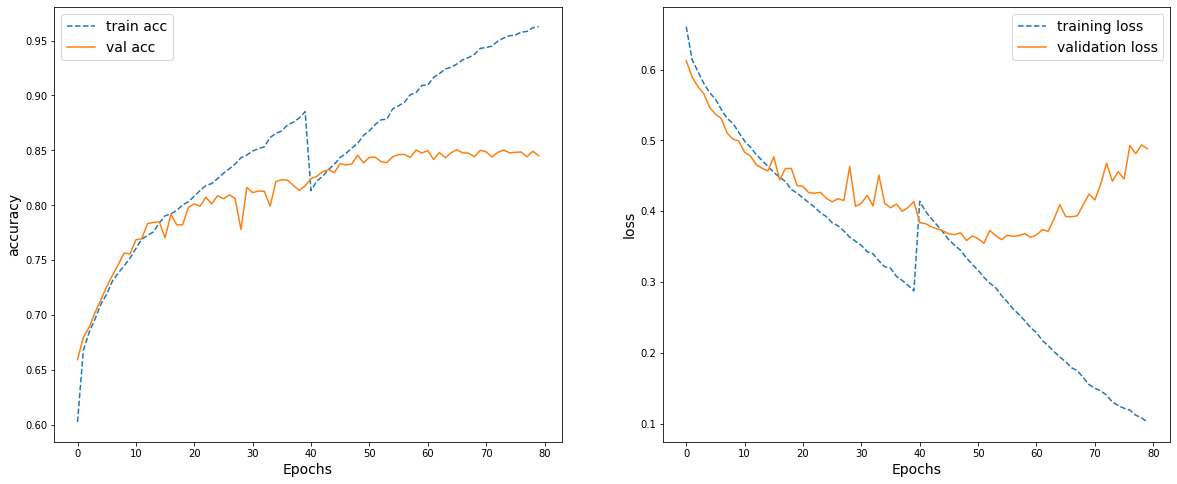

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))

# flatting lists
train_acc_flat = [item for sublist in train_acc for item in sublist]
train_loss_flat = [item for sublist in train_loss for item in sublist]
val_acc_flat = [item for sublist in val_acc for item in sublist]
val_loss_flat = [item for sublist in val_loss for item in sublist]

ax[0].plot(train_acc_flat, '--', 
         label = 'train acc')

ax[0].plot(val_acc_flat, 
         label = 'val acc') 

fontsize = 14
ax[0].set_ylabel('accuracy', fontsize=fontsize)
ax[0].set_xlabel('Epochs', fontsize=fontsize)
ax[0].legend(fontsize=fontsize)    
    
ax[1].plot(train_loss_flat, '--', 
         label = 'training loss')

ax[1].plot(val_loss_flat, 
         label = 'validation loss') 

ax[1].set_ylabel('loss', fontsize=fontsize)
ax[1].set_xlabel('Epochs', fontsize=fontsize)
ax[1].legend(fontsize=fontsize)    

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy

N_data = len(X_test) # number of sequences
len_seq = len(X_test[0]) + 1 # number of digits per sequence

print('** Starting converting to distances')
filter_dim = model.layers[0].get_weights()[0].shape[0]
X_test_dis = np.zeros(shape = (N_data ,len_seq + filter_dim ,len_seq + filter_dim), dtype=np.float16)

for idx, seq in enumerate(X_test):

    fcx, fcy, fcz, _, _, _ = seq_to_coords(seq) # transcription of the sequence
    d = np.zeros(shape=(len_seq, len_seq))
    for i in range(0, len_seq):
        d[i,:] = edist(fcx[i], fcy[i], fcz[i], fcx, fcy,fcz)
    d = (d - np.min(d))/( np.max(d) - np.min(d) ) # scaling
    X_test_dis[idx] = matrix_pad(d, filter_dim) # padding

print(f'** Process Completed for {N_data} sequences')

X_test_dis = X_test_dis.reshape(N_data, len_seq + filter_dim, len_seq + filter_dim, 1)

p = model.predict(X_test_dis)
m = BinaryAccuracy(name = 'binary_accuracy', 
                   threshold = 0.5)
                   # if predict is < 0.5 then it's considered as 0
                  
m.update_state(Y_test, p) # feeding labels
acc_test = m.result().numpy() # result
print(acc_test)

** Starting converting to distances
** Process Completed for 3788 sequences
0.8513728


In [ ]:
from sklearn.metrics import confusion_matrix 
# round(): se <= .5 allora diventa 0 (come per la BinaryAccuracy)
c_matrix = confusion_matrix(Y_test, p.round(), normalize='true',
                           labels=[0,1])
print(c_matrix)

[[0.84160507 0.15839493]
 [0.13885956 0.86114044]]


In [ ]:
# NOTA: ricorda che X_test è composto dal 50% di knot e 50%
# di unknot, così da avere una predizione su sempre lo stesso set 
# e bilanciato tra le due classi.

## 50 50, labels=[0,1]
# norm = true
# [[0.82154171 0.17845829]
#  [0.14625132 0.85374868]]
# norm = all
# [[0.41077086 0.08922914]
#  [0.07312566 0.42687434]]

## 42 knot 58 unknot, labels=[0,1]
# norm = true
# [[0.83104541 0.16895459]
#  [0.14149947 0.85850053]]
# norm = all
# [[0.4155227  0.0844773 ]
#  [0.07074974 0.42925026]]

## 38 knot 62 unknot, labels=[0,1]
# norm = true
# [[0.8938754  0.1061246 ]
#  [0.22756072 0.77243928]]
# norm = all
# [[0.4469377  0.0530623 ]
#  [0.11378036 0.38621964]]

In [ ]:
from datetime import datetime

today = datetime.now().date().strftime('%d-%m-%Y')
model.save(f'N200_main_{today}.model')
print('Model saved') 

np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: N200_main_22-06-2020.model/assets
Model saved
